In [ ]:
#imports
import pandas as pd
import numpy as np
import scipy as sp
import tensorflow as tf
import matplotlib.pyplot as plt
from numpy.random import normal
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from tensorflow.keras.datasets.mnist import load_data
from torch.utils.data import TensorDataset
random.seed(100)
plt.style.use('seaborn')

In [ ]:
# Noise Functions
def add_gaussian_noise(images):
    n,r,c = images.shape
    out = np.zeros((n,r,c))
    out = images + np.random.normal(loc=0.0, scale=.25, size=(r,c))
    return np.clip(out,0,1)

def add_salt_and_pepper(images):
    sigma = .25
    scale = 1.5
    n,r,c = images.shape
    out = np.zeros((n,r,c))
    salt = np.random.normal(loc=0.0, scale=sigma, size=(r,c))
    pepper = np.random.normal(loc=0.0, scale=sigma, size=(r,c))
    salt[salt > sigma*scale] = 0
    salt[salt <= sigma*scale] = 1
    pepper[pepper < sigma*scale] = 0
    pepper[pepper >= sigma*scale] = 1
    out = salt * (pepper + images)
    return np.clip(out,0,1)

In [ ]:
# mnist dataset & setting up variables
train_cut = 20000
test_cut = 10000
X_train = load_data(path="mnist.npz")[0][0]/255
X_train = X_train[:train_cut,:,:]
y_train = load_data(path="mnist.npz")[0][1]
X_test = load_data(path="mnist.npz")[1][0]/255
y_test = load_data(path="mnist.npz")[1][1]
X_train_g = add_gaussian_noise(X_train)
X_train_sp = add_salt_and_pepper(X_train)
X_test_g = add_gaussian_noise(X_test)
X_test_sp = add_salt_and_pepper(X_test)

# torch from numpy
tensor_imgs_clean = torch.from_numpy(np.array(X_train.reshape(train_cut,784)).astype(np.float32))
tensor_imgs_Gnoisy = torch.from_numpy(np.array(X_train_g.reshape(train_cut,784)).astype(np.float32))
tensor_imgs_SPnoisy = torch.from_numpy(np.array(X_train_sp.reshape(train_cut,784)).astype(np.float32))
tensor_imgs_test = torch.from_numpy(np.array(X_test.reshape(test_cut, 784)).astype(np.float32))
tensor_imgs_Gtest = torch.from_numpy(np.array(X_test_g.reshape(test_cut,784)).astype(np.float32))
tensor_imgs_SPtest = torch.from_numpy(np.array(X_test_sp.reshape(test_cut,784)).astype(np.float32))

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
# Gaussian convolution
def denoise_gaussian(images):
    n,r,c = images.shape
    out = np.zeros((n,r,c))
    for i in range(n):
        out[i,:,:] = sp.ndimage.gaussian_filter(images[i,:,:],0.75)
    out_scaled = MinMaxScaler().fit_transform(out.reshape((n,r*c)).T)
    return out_scaled.T.reshape((n,r,c))

In [ ]:
# PCA
def get_eigs_pca(images):
    n,r,c = images.shape
    images_re = images.reshape((n,r*c))
    out = np.zeros((n,r*c))
    eig_count = 500
    pca = PCA()
    pca.fit(images_re)
    eigen_vecs = pca.components_
    comps = eigen_vecs[:eig_count,:]
    return comps
  
def denoise_pca(images,comps):
    n,r,c = images.shape
    images_re = images.reshape((n,r*c))
    out = np.zeros((n,r*c))
    out = images_re@comps.T@comps
    out_scaled = MinMaxScaler().fit_transform(out.reshape((n,r*c)).T)
    return out_scaled.T.reshape((n,r,c))

In [ ]:
# autoencoder

# autoencoder model
denoiser = nn.Sequential(
      nn.Linear(784,128),
      #nn.LeakyReLU(),
      nn.ReLU(),
      nn.Linear(128,784),
      nn.Sigmoid()
  )

def denoise(images):
  # define loss & variables
  loss_fn = torch.nn.MSELoss()
  lr = 0.1
  N = 64
  indices = [i for i in range (images.shape[0])]

  # train model 
  for t in range (30000):
    # create batch 
    batch_ind = random.sample(indices, N)
    y_pred = denoiser(images[batch_ind])
    loss = loss_fn(y_pred, tensor_imgs_clean[batch_ind])
    #if t % 1000 == 999:
          #print(t, loss.item())
    denoiser.zero_grad()
    loss.backward()
    with torch.no_grad():
          for param in denoiser.parameters():
              param -= lr * param.grad 

  denoised_samples = denoiser(images)
  denoised_samples = denoised_samples.detach().numpy()

  return(denoised_samples)

In [ ]:
# calling models
# gaussian convolution
X_train_g_g = denoise_gaussian(X_train_g)
X_train_sp_g = denoise_gaussian(X_train_sp)

# PCA
eigs_g = get_eigs_pca(X_train_g)
eigs_sp = get_eigs_pca(X_train_sp)
X_train_g_p = denoise_pca(X_train_g,eigs_g)
X_train_sp_p = denoise_pca(X_train_sp,eigs_sp)
X_test_g_p = denoise_pca(X_test_g[:test_cut,:,:],eigs_g)
X_test_sp_p = denoise_pca(X_test_sp[:test_cut,:,:],eigs_sp)

# autoencoder
denoised_G = denoise(tensor_imgs_Gnoisy).reshape(train_cut,28,28)
denoised_G_test = denoiser(tensor_imgs_Gtest)
denoised_G_test = denoised_G_test.detach().numpy().reshape(test_cut,28,28)
denoised_SP = denoise(tensor_imgs_SPnoisy).reshape(train_cut,28,28)
denoised_SP_test = denoiser(tensor_imgs_SPtest)
denoised_SP_test = denoised_SP_test.detach().numpy().reshape(test_cut,28,28)

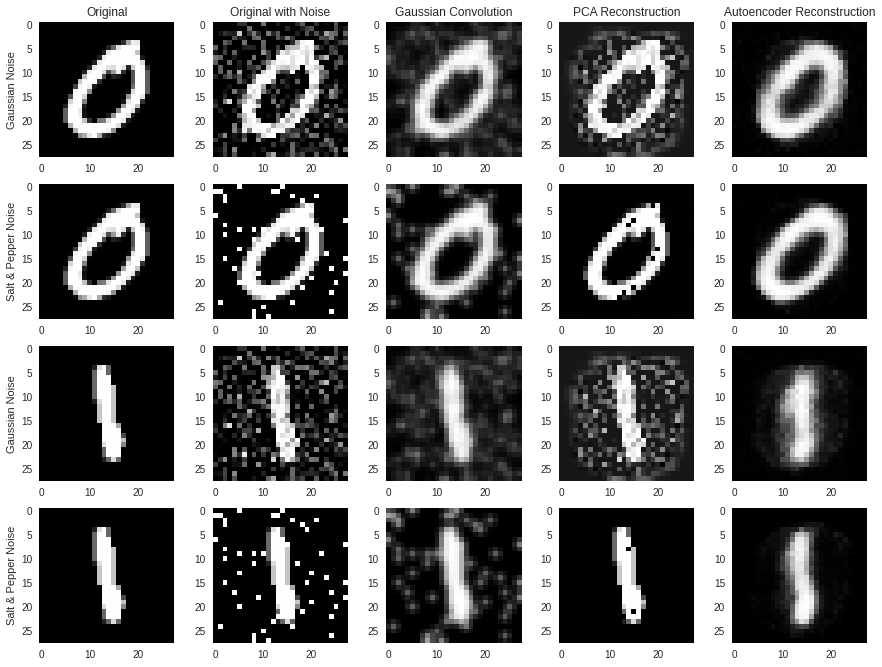

In [ ]:
# Show two samples and their results
s = [639,200] 
d_g = [X_train,X_train_g,X_train_g_g,X_train_g_p,denoised_G]
d_sp = [X_train,X_train_sp,X_train_sp_g,X_train_sp_p,denoised_SP]
t_x = ["Original","Original with Noise","Gaussian Convolution", "PCA Reconstruction", "Autoencoder Reconstruction"]
t_y = ["Gaussian Noise","Salt & Pepper Noise"]

plt.rcParams["axes.grid"] = False

fig, axs = plt.subplots(2*len(s), 5, figsize=(15,15))

for i,n in enumerate(s):
  for j in range(len(d_g)):
    axs[2*i][j].imshow(d_g[j][n], cmap="Greys_r")
    axs[2*i+1][j].imshow(d_sp[j][n], cmap="Greys_r")
    
for i,t in enumerate(t_x):
  axs[0][i].set_title(t)

for i in [0,len(s)]:
  for j,t in enumerate(t_y):
    axs[i+j][0].set_ylabel(t)

fig.subplots_adjust(top=0.7)

plt.savefig('figure1.png')

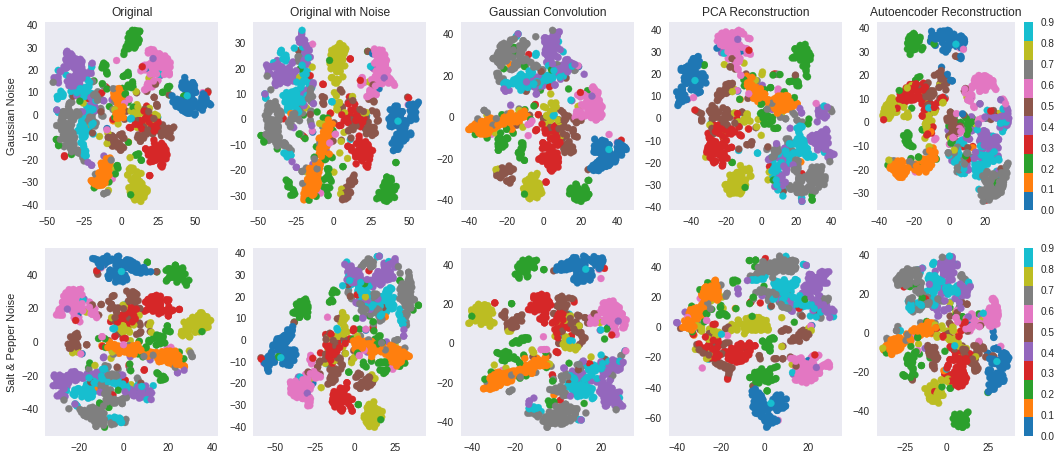

In [ ]:
# Clustering visual

plt.rcParams["axes.grid"] = False

fig, axs = plt.subplots(2, 5, figsize=(18,10))

d_all = [X_train,X_train_g,X_train_g_g,X_train_g_p,denoised_G,X_train,X_train_sp,X_train_sp_g,X_train_sp_p,denoised_SP]

cut = 1000
y_viz = y_train[:cut]/10
cmp = plt.get_cmap("tab10", 10)
for i,ax in enumerate(axs.flat):
  X_viz = d_all[i][:cut,:,:]
  n,r,c = X_viz.shape
  tsne = TSNE()
  reduced = tsne.fit_transform(X_viz.reshape((n,r*c)))
  im = ax.scatter(reduced[:,0],reduced[:,1],c=y_viz,cmap=cmp)
    
for i,t in enumerate(t_x):
  axs[0][i].set_title(t)

for i,t in enumerate(t_y):
  axs[i][0].set_ylabel(t)

plt.colorbar(im,ax=axs[0,4])
plt.colorbar(im,ax=axs[1,4])
fig.subplots_adjust(top=0.7)

plt.savefig('figure2.png')

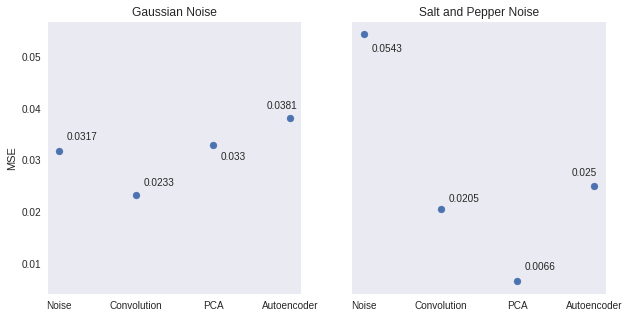

In [ ]:
# Training errors

d_g = [X_train_g,X_train_g_g,X_train_g_p,denoised_G]
d_sp = [X_train_sp,X_train_sp_g,X_train_sp_p,denoised_SP]
mse_g = np.zeros(len(d_g))
mse_sp = np.zeros(len(d_sp))
for i in range(len(d_g)):
  n,r,c = X_train.shape
  mse_g[i] = mean_squared_error(X_train.reshape(n,r*c),d_g[i].reshape(n,r*c))
  mse_sp[i] = mean_squared_error(X_train.reshape(n,r*c),d_sp[i].reshape(n,r*c))

fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)
labs = ["Noise","Convolution", "PCA", "Autoencoder"]
axs[0].scatter(labs,mse_g)
axs[0].title.set_text("Gaussian Noise")
axs[1].scatter(labs,mse_sp)
axs[1].title.set_text("Salt and Pepper Noise")
axs[0].set_ylabel("MSE")

axs[0].annotate(f"{round(mse_g[0],4)}", (0.1,0.034))
axs[0].annotate(f"{round(mse_g[1],4)}", (1.1,0.025))
axs[0].annotate(f"{round(mse_g[2],4)}", (2.1,0.03))
axs[0].annotate(f"{round(mse_g[3],4)}", (2.7,0.04))

axs[1].annotate(f"{round(mse_sp[0],4)}", (0.1,0.051))
axs[1].annotate(f"{round(mse_sp[1],4)}", (1.1,0.022))
axs[1].annotate(f"{round(mse_sp[2],4)}", (2.1,0.0088))
axs[1].annotate(f"{round(mse_sp[3],4)}", (2.7,0.027))

plt.savefig('figure3.png')

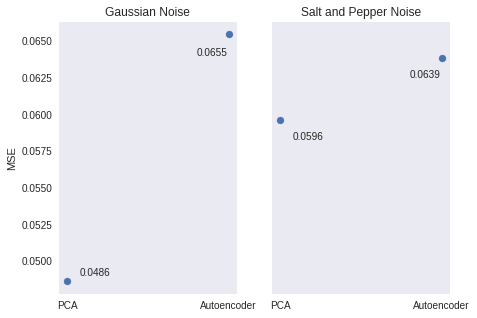

In [ ]:
# Test errors
X_test = X_test[:test_cut,:,:]
d_g = [X_test_g_p,denoised_G_test]
d_sp = [X_test_sp_p,denoised_SP_test]
mse_g = np.zeros(len(d_g))
mse_sp = np.zeros(len(d_sp))
for i in range(len(d_g)):
  n,r,c = X_test.shape
  mse_g[i] = mean_squared_error(X_test.reshape(n,r*c),d_g[i].reshape(n,r*c))
  mse_sp[i] = mean_squared_error(X_test.reshape(n,r*c),d_sp[i].reshape(n,r*c))

fig, axs = plt.subplots(1, 2, figsize=(7,5), sharey=True)
labs = ["PCA", "Autoencoder"]

axs[0].scatter(labs,mse_g)
axs[0].title.set_text("Gaussian Noise")
axs[1].scatter(labs,mse_sp)
axs[1].title.set_text("Salt and Pepper Noise")
axs[0].set_ylabel("MSE")

axs[0].annotate(f"{round(mse_g[0],4)}", (0.08,0.049))
axs[0].annotate(f"{round(mse_g[1],4)}", (0.8,0.064))

axs[1].annotate(f"{round(mse_sp[0],4)}", (0.08,0.0583))
axs[1].annotate(f"{round(mse_sp[1],4)}", (0.8,0.0625))

plt.savefig('figure4.png')